In [243]:
words = open('names.txt').read().splitlines()

In [244]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [245]:
len(words)

32033

In [246]:
min(len(w) for w in words)

2

In [247]:
max(len(w) for w in words)

15

In [248]:
b = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        bigram = (c1, c2)
        b[bigram] = b.get(bigram, 0) + 1

In [249]:
sorted(b.items(), key=lambda kv: -kv[1],)[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

In [250]:
# Use pytorch for multidimensional array of indexed counts
import torch

In [251]:
# Add lookup for charaters
c_index = sorted(list(set(''.join(words))))
c_index = ['.'] + c_index
stoi = {ch: i for i, ch in enumerate(c_index)}
itos = {i: ch for i, ch in enumerate(c_index)}  

In [252]:
# Create counts of character bigrams
N = torch.zeros(len(c_index), len(c_index), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        N[stoi[c1], stoi[c2]] += 1


(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

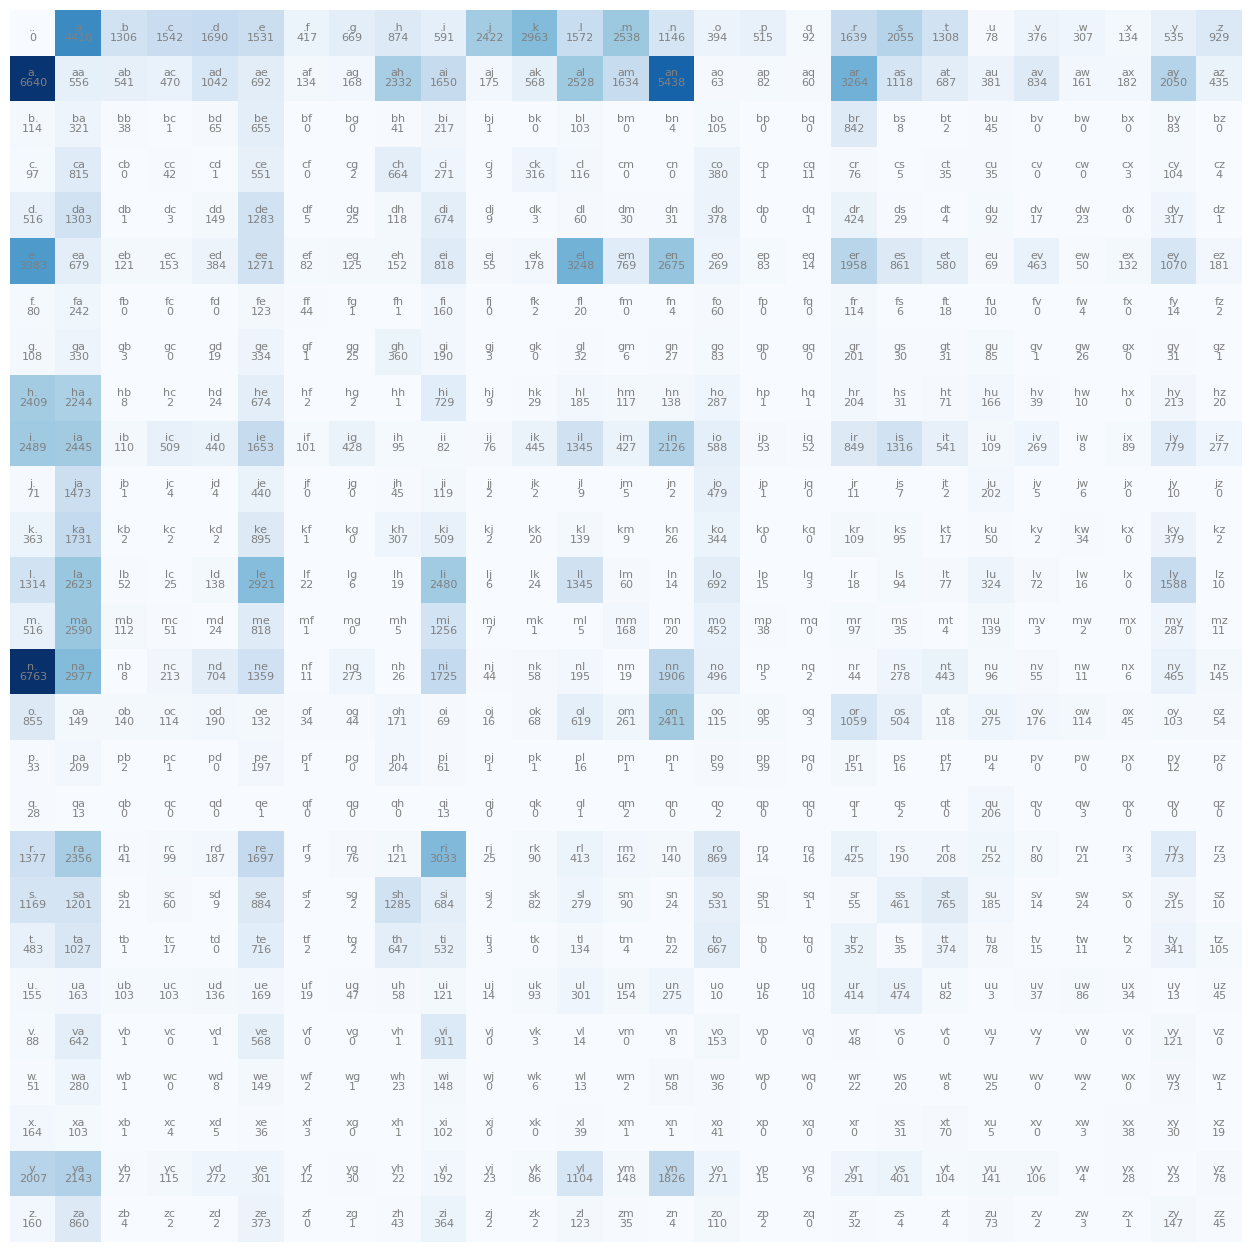

In [253]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(len(c_index)):
    for j in range(len(c_index)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray', fontsize=8)
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray', fontsize=8)
plt.axis('off')

In [254]:
# Start of a word
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [255]:
# Convert N into probabilities
P = N.float()
P = P / P.sum(dim=1, keepdim=True)

In [256]:
# Sampling 10 examples from the distribution
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    current_token = "."
    sampled_name = [current_token]

    while len(sampled_name) <= 1 or current_token != ".":
        current_index = stoi[current_token]
        probs = P[current_index]
        next_index = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        next_token = itos[next_index]
        sampled_name.append(next_token)
        current_token = next_token
        
    print(''.join(sampled_name)[1:-1])

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


In [257]:
# Make more efficient by using probabilities (with smoothing)
P = N.float() + 1.0  # add-one smoothing
P = P / P.sum(dim=1, keepdim=True)

In [258]:
# Determine neg log likelihood on the training set (maximum likelihood training)
nll = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        i1 = stoi[c1]
        i2 = stoi[c2]
        prob = P[i1, i2]
        nll += -torch.log(prob)
        n += 1
nll /= n
nll.item()

2.4543561935424805

In [259]:
# Part 2: Cast bigram modeling of bigrams in neural network framework

In [274]:
# Create training set of all bigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        i1 = stoi[c1]
        i2 = stoi[c2]
        xs.append(i1)
        ys.append(i2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [275]:
print(xs)
print(ys)

tensor([ 0,  5, 13,  ..., 25, 26, 24])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [268]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=len(c_index)).float()

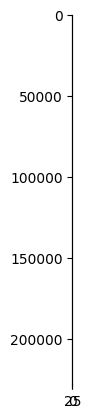

In [269]:
plt.imshow(xenc)

In [286]:
# Randomly with fixed seed
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# Implement training over each examples in x
lr = 50.0
    
# Iterate over xs and ys in batch of size 1
for k in range(1):
    for i in torch.randperm(len(xs[:1])):
        x = xs[i:i+1]
        y = ys[i:i+1]
        print(x, y)
        xenc = F.one_hot(x, num_classes=len(c_index)).float()
        # print(xenc)
        logits = xenc @ W
        # print(logits)
        
        # get class probabilities - similar to counts normalization above
        # get NLL by taking the neg logprob of the true class
        # logprobs = logits.log_softmax(dim=1)
        # nll = -logprobs[0, y]
        # equivalent to: cross entropy loss
        nll = F.cross_entropy(logits, y)
        
        # print(logprobs)
        print(nll)
        # gradient descent step
        print(W[0, :])
        W.grad = None
        nll.backward()
        print(W.grad)
        W.data -= lr * W.grad
        print(W[0, :])
        
    # vectorized loss
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W
    loss = F.cross_entropy(logits, ys)
    print(f"iter {k}: loss {loss.item():.4f}")

tensor([0]) tensor([5])
tensor(4.3993, grad_fn=<NllLossBackward0>)
tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046, -0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,
         1.5618, -1.6261,  0.6772, -0.8404,  0.9849, -0.1484, -1.4795,  0.4483,
        -0.0707,  2.4968,  2.4448], grad_fn=<SelectBackward0>)
None
tensor([-1.4663, -0.7364, -0.6431, -1.3113, -0.5563, 49.3560, -1.6818, -0.5538,
        -0.6058, -0.6590, -0.8663, -0.6031, -0.7841, -0.8434, -1.1247, -8.9574,
        -1.4550, -1.7505, -0.5684, -1.1135, -0.7094, -0.6939, -1.6236, -0.5424,
        -0.6603, -5.1875, -4.8502], grad_fn=<SelectBackward0>)
iter 0: loss 9.9159


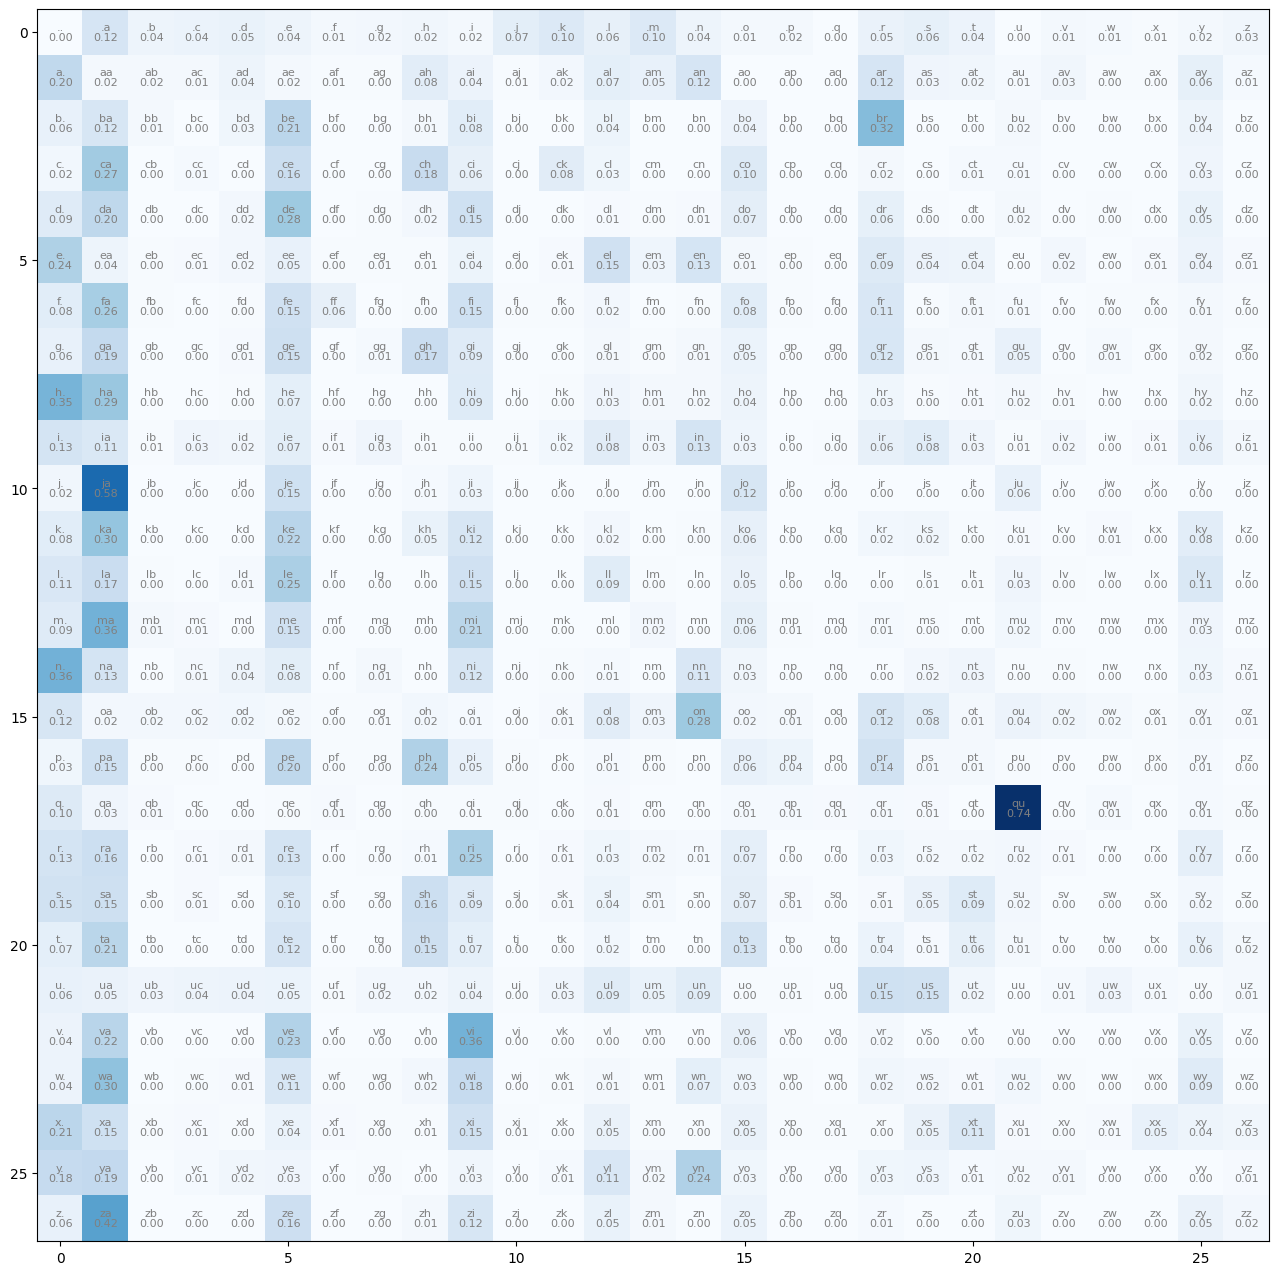

In [272]:
# Print W similar to rendering counts above
# First convert W to probabilities
W_probs = W.exp()
W_probs = W_probs / W_probs.sum(dim=1, keepdim=True)
plt.figure(figsize=(16,16))
plt.imshow(W_probs.detach().numpy(), cmap='Blues')
for i in range(len(c_index)):
    for j in range(len(c_index)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray', fontsize=8)
        plt.text(j, i, f"{W_probs[i,j].item():.2f}", ha='center', va='top', color='gray', fontsize=8)


(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

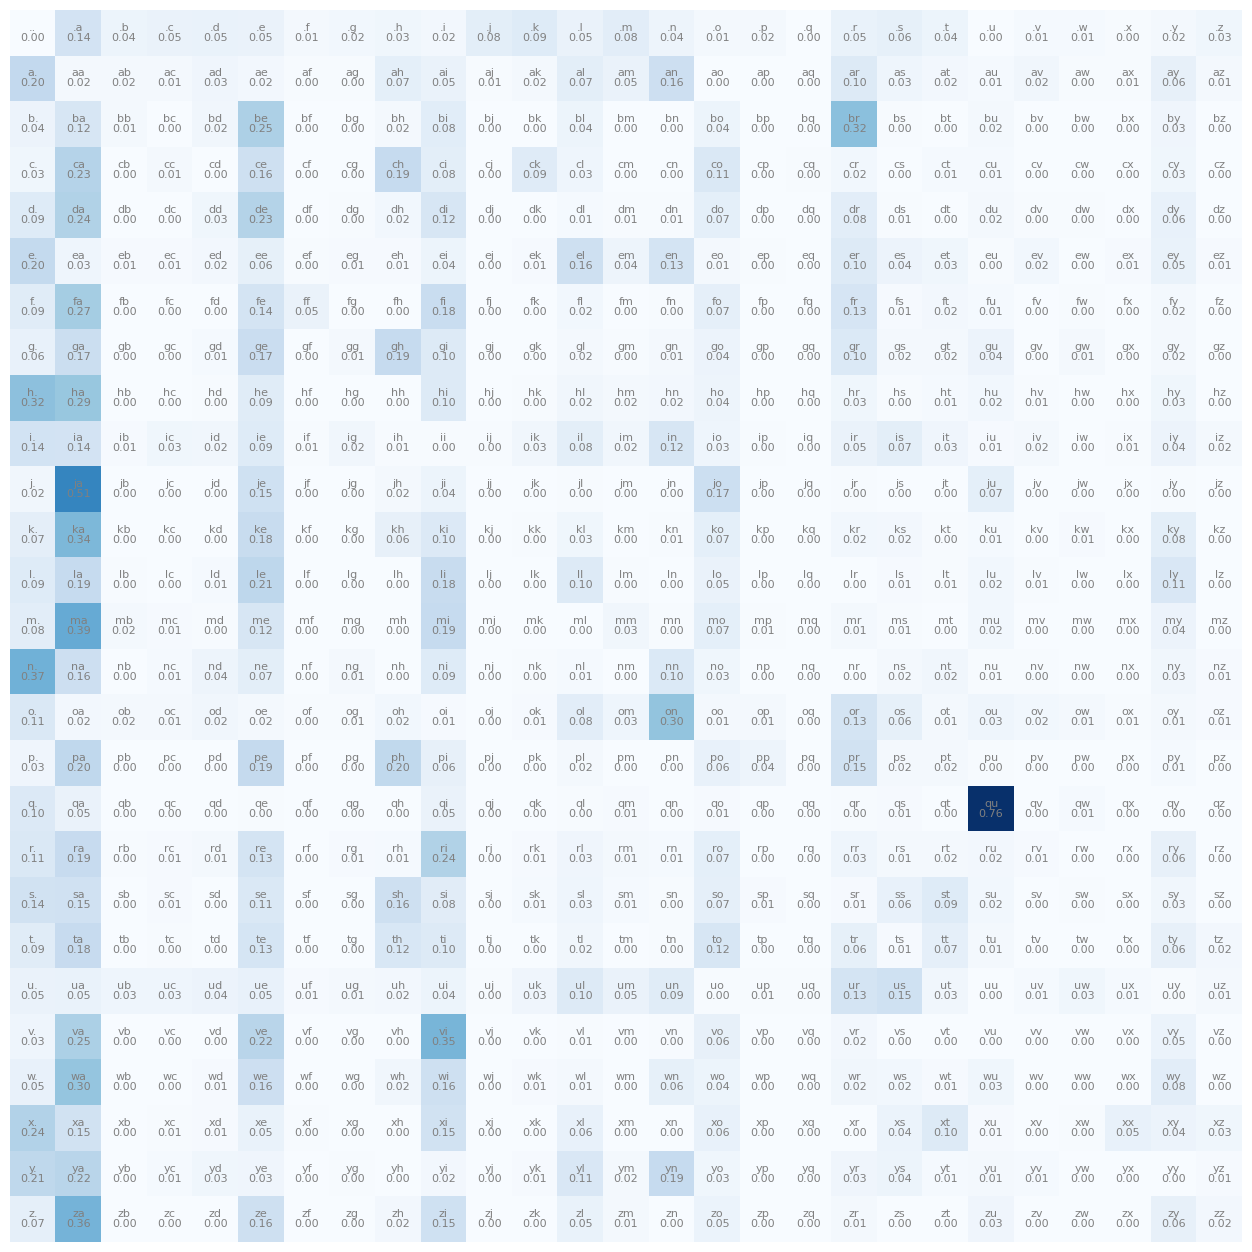

In [ ]:
# For equivalence need to print counts as probabilities per row as well
N_probs = N.float()
N_probs = N_probs / N_probs.sum(dim=1, keepdim=True)
plt.figure(figsize=(16,16))
plt.imshow(N_probs, cmap='Blues')
for i in range(len(c_index)):
    for j in range(len(c_index)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray', fontsize=8)
        plt.text(j, i, f"{N_probs[i,j].item():.2f}", ha='center', va='top', color='gray', fontsize=8)
plt.axis('off')

In [ ]:
# Part 2 following the official video tutorial - mark via BETTER what is improved

In [ ]:
# Create training set of all bigrams
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        i1 = stoi[c1]
        i2 = stoi[c2]
        xs.append(i1)
        ys.append(i2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
# Randomly with fixed seed
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [ ]:
xenc = F.one_hot(xs, num_classes=len(c_index)).float() # input to the nn
logits = xenc @ W # interpret as logits for next character prediction (=log counts)
counts = logits.exp() # at least looks like counts
probs = counts / counts.sum(dim=1, keepdim=True)
probs # probabilities derived in fully differentiable manner

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [ ]:
probs.shape

torch.Size([5, 27])

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286250479519367
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

In [ ]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
print(loss.item())

3.7091546058654785


In [ ]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [ ]:
W.data += -0.1 * W.grad # -> loss now decreased

In [ ]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [ ]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

2.4899587631225586
2.4897916316986084
2.489628553390503
2.489469289779663
2.489314079284668
2.4891624450683594
2.4890148639678955
2.48887038230896
2.48872971534729
2.4885921478271484
2.4884581565856934
2.4883270263671875
2.488198757171631
2.4880735874176025
2.4879510402679443
2.4878318309783936
2.487715005874634
2.487600564956665
2.4874887466430664
2.487380027770996
2.4872729778289795
2.487168312072754
2.4870662689208984
2.486966133117676
2.4868686199188232
2.4867727756500244
2.4866793155670166
2.4865872859954834
2.486497163772583
2.4864091873168945
2.486323118209839
2.486238718032837
2.4861562252044678
2.4860751628875732
2.4859957695007324
2.4859180450439453
2.485841751098633
2.485767126083374
2.4856936931610107
2.485621929168701
2.4855518341064453
2.485482692718506
2.485414981842041
2.4853484630584717
2.485283374786377
2.4852190017700195
2.485156536102295
2.4850947856903076
2.485034465789795
2.4849750995635986
2.484916925430298
2.4848599433898926
2.4848034381866455
2.484748601913452


In [ ]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))